<a href="https://colab.research.google.com/github/sacontreras/dsc-mod-4-project-v2-1-online-ds-sp-000/blob/master/mod4-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download images if we haven't already...

In [1]:
import tensorflow as tf
import urllib
import urllib.request
from tqdm.auto import tqdm
import numpy as np
import os
import zipfile

def download(url, local_fname, block_sz=8192):
  http_file = urllib.request.urlopen(url)
  if http_file.getcode() != 200:
      raise ValueError(f"ERROR {http_file.getcode()} while opening {url}.")

  meta = http_file.info()
  file_size = int(meta['Content-Length'])
  print(f"Downloading {url} (filesize: {file_size} bytes) to {local_fname}...")
  print()

  f = None
  try:
    f = open(local_fname, 'wb')
    file_size_dl = 0
    fblocks = np.arange(start=0, stop=file_size+1, step=block_sz)
    tqdm_pb = tqdm(fblocks)
    for tfblock in tqdm_pb: 
        buffer = http_file.read(block_sz)
        if not buffer:
            break
        file_size_dl += len(buffer)
        f.write(buffer)
  finally:
    if f is not None:
      f.close()

  file_size_local = os.path.getsize(f.name)
  if file_size_local != file_size:
      raise ValueError(f"URL file {url} is {file_size} bytes but we only downloaded {file_size_local} bytes to local file {local_fname}.")
  else:
      print(f"Successfully downloaded {file_size_local}/{file_size} bytes from URL file {url} to local file {local_fname}!")
  return 0




# two different "current" dataset URLs:
# 1. https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip
# 2. https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/810b2ce2-11c3-4424-996e-3bef36600907/file_downloaded

images_download_URL = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip'

root_dir = './' # '/tmp'
images_root = os.path.join(root_dir, 'CellData')

if not os.path.isdir(images_root):
  local_archive_fname = 'mod-4-images.zip'
  images_archive = os.path.join(root_dir, local_archive_fname)

  download(images_download_URL, images_archive, block_sz=1024**2)

  images_archive_2 = os.path.join(root_dir, "ZhangLabData.zip")
  print(f"unzipping {images_archive} to {images_archive_2}...")
  zip_ref = zipfile.ZipFile(images_archive, 'r')
  zip_ref.extractall(root_dir) # this will unzip to another archive: /tmp/ZhangLabData.zip
  zip_ref.close()
  print(f"\tDONE")
  print(f"deleting {images_archive}...")
  os.remove(images_archive)
  print(f"\tDONE")

  # now unzip ZhangLabData.zip
  print(f"unzipping {images_archive_2} to {images_root}...")
  zip_ref = zipfile.ZipFile(images_archive_2, 'r')
  zip_ref.extractall(root_dir) # this will unzip to: /tmp/CellData
  zip_ref.close()
  print(f"\tDONE")
  print(f"deleting {images_archive_2}...")
  os.remove(images_archive_2)
  print(f"\tDONE")
else:
  print(f"{images_root} already exists locally - skipping download")

./CellData already exists locally - skipping download


# Get labeled image pathnames and filter out non-image files...

In [2]:
# the images we are interested in:
#{root_dir}
# |- CellData
#    |- chest_xray
#       |- test
#          |- NORMAL
#          |- PNEUMONIA
#       |- train
#          |- NORMAL
#          |- PNEUMONIA

# images_root = '/tmp/CellData' # from above
images_root = os.path.join(images_root, 'chest_xray')

train_dir = os.path.join(images_root, 'train')
test_dir = os.path.join(images_root, 'test')

train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Directory with our training normal/pneumonia xrays
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

def list_images(dir):
  return list(filter(lambda fn: fn.endswith('.jpeg') or fn.endswith('.jpg') or fn.endswith('.png'), os.listdir(dir)))

train_normal_fnames = list_images(train_normal_dir)
n_train_normal = len(train_normal_fnames)
print(f'total training NORMAL images: {n_train_normal}')
train_pneumonia_fnames = list_images(train_pneumonia_dir)
n_train_pneumonia = len(train_pneumonia_fnames)
print(f'total training PNEUMONIA images: {n_train_pneumonia}')
n_train = n_train_normal + n_train_pneumonia

test_normal_fnames = list_images(test_normal_dir)
n_test_normal = len(test_normal_fnames)
print(f'total test NORMAL images: {n_test_normal}')
test_pneumonia_fnames = list_images(test_pneumonia_dir)
n_test_pneumonia = len(test_pneumonia_fnames)
print(f'total test PNEUMONIA images: {n_test_pneumonia}')
n_test = n_test_normal + n_test_pneumonia

train_normal_image_paths = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames]
train_pneumonia_image_paths = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames]
test_normal_image_paths = [os.path.join(test_normal_dir, fname) for fname in test_normal_fnames]
test_pneumonia_image_paths = [os.path.join(test_pneumonia_dir, fname) for fname in test_pneumonia_fnames]

total training NORMAL images: 1349
total training PNEUMONIA images: 3883
total test NORMAL images: 234
total test PNEUMONIA images: 390


# Explore the Dataset

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

## Re-run the following cell to see a different set of images

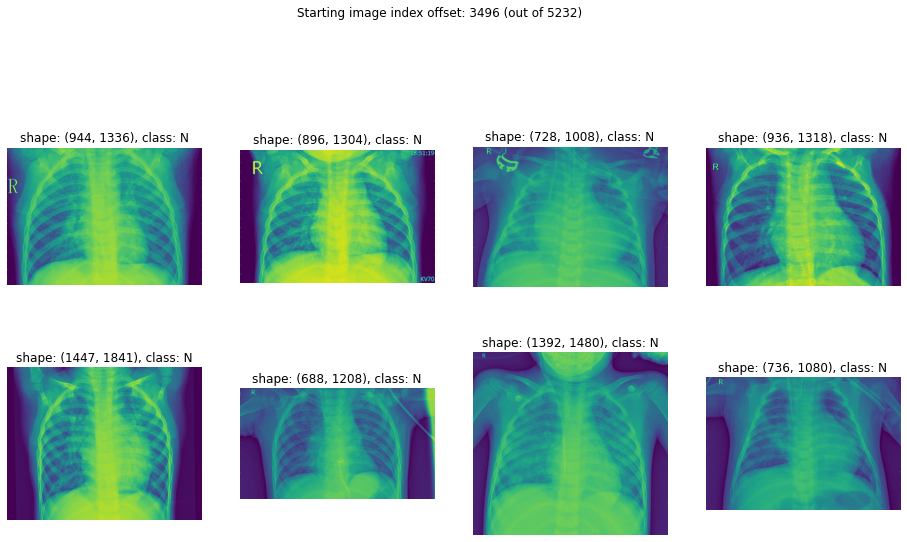

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index = random.randint(0,int(n_train/8)-1)*8

next_normal_pix = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[pic_index-8:pic_index]]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
  plt.suptitle(f"Starting image index offset: {pic_index} (out of {n_train})")
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  im = Image.open(img_path)
  im_as_array = np.array(im)
  sp.set_title(f"shape: {im_as_array.shape}, class: {'N' if i<8 else 'P'}")
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Get a feel for the range of all image shapes

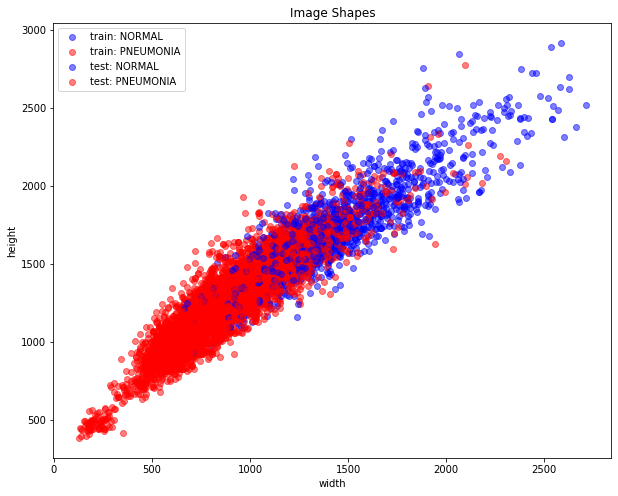

mean shape: (974, 1328)


In [5]:
fig = plt.figure(figsize=(10,8))
plt.title('Image Shapes')
plt.xlabel('width')
plt.ylabel('height')
smallest = None
biggest = None
W_all = []
H_all = []
for i, t_image_paths in enumerate([(train_normal_image_paths, train_pneumonia_image_paths), (test_normal_image_paths, test_pneumonia_image_paths)]):
  for j, img_paths in enumerate(t_image_paths):
    W = []
    H = []
    for img_path in img_paths:
      try:
        im = Image.open(img_path)
        im_as_array = np.array(im)
        w = im_as_array.shape[0]
        W.append(w)
        W_all.append(w)
        h = im_as_array.shape[1]
        H.append(h)
        H_all.append(h)
        n_pixels = w*h
        if smallest == None or n_pixels < smallest[0][0]*smallest[0][1]:
          smallest = ((w,h), img_path)
        if biggest == None or n_pixels > biggest[0][0]*biggest[0][1]:
          biggest = ((w,h), img_path)
      except:
        pass
    plt.scatter(W, H, c='blue' if j==0 else 'red', alpha=0.5, label=f"{'train' if i==0 else 'test'}: NORMAL" if j==0 else f"{'train' if i==0 else 'test'}: PNEUMONIA")
plt.legend()
plt.show()

mean_shape = (int(np.mean(W_all)), int(np.mean(H_all)))
print(f"mean shape: ({mean_shape[0]}, {mean_shape[1]})")

smallest: ((127, 384), './CellData/chest_xray/train/PNEUMONIA/VIRUS-355597-0002.jpeg')


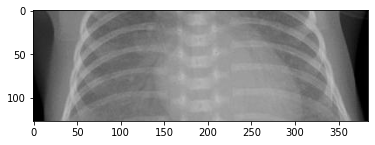

In [6]:
print(f"smallest: {smallest}")
img = mpimg.imread(smallest[1])
plt.imshow(img);

biggest: ((2583, 2916), './CellData/chest_xray/train/NORMAL/NORMAL-9990348-0001.jpeg')


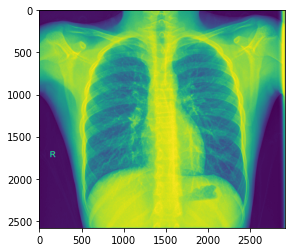

In [7]:
print(f"biggest: {biggest}")
img = mpimg.imread(biggest[1])
plt.imshow(img);

In [8]:
# (150,150) was the first shape I used but that shape did not seem to pass enough information to the NN
# The mean shape is close to (1024,1024) but this is WAY overkill and causes the NN to greatly overfit
#    and it also takes a VERY long time to train
# I tried halving to (512,512) with very little to no improvement over (1024,1024)
# But (300,300) seems to be the sweet spot
input_shape = (150,150)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255 but, most importantly, we will use data augmentation to simulate a bigger training set
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)
train_batch_size = 20
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=train_batch_size, 
    class_mode='binary',
    target_size=input_shape
)

test_datagen = ImageDataGenerator(rescale = 1.0/255.) # obviously we leave the test set untouched by augmentation; however, we do scale it
val_batch_size = 20
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=val_batch_size,
    class_mode='binary',
    target_size=input_shape
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(input_shape[0],input_shape[1],3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2), # experiment
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [11]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics = ['accuracy']
)

In [12]:
history = model.fit(
    train_generator,
    epochs=15,
    # steps_per_epoch=int(n_train/train_batch_size),

    validation_data=validation_generator,
    # validation_steps=int(n_test/val_batch_size),

    verbose=1
)

Epoch 1/15
262/262 [==============================] - 77s 294ms/step - loss: 0.5446 - accuracy: 0.7378 - val_loss: 0.7099 - val_accuracy: 0.6186
Epoch 2/15
262/262 [==============================] - 77s 293ms/step - loss: 0.4421 - accuracy: 0.7775 - val_loss: 0.4485 - val_accuracy: 0.7756
Epoch 3/15
262/262 [==============================] - 77s 294ms/step - loss: 0.3362 - accuracy: 0.8459 - val_loss: 0.4533 - val_accuracy: 0.7564
Epoch 4/15
262/262 [==============================] - 77s 294ms/step - loss: 0.3018 - accuracy: 0.8687 - val_loss: 0.3873 - val_accuracy: 0.8173
Epoch 5/15
262/262 [==============================] - 76s 291ms/step - loss: 0.2713 - accuracy: 0.8792 - val_loss: 0.3556 - val_accuracy: 0.8413
Epoch 6/15
262/262 [==============================] - 75s 287ms/step - loss: 0.2547 - accuracy: 0.8880 - val_loss: 0.4451 - val_accuracy: 0.7692
Epoch 7/15
262/262 [==============================] - 76s 289ms/step - loss: 0.2516 - accuracy: 0.8960 - val_loss: 0.3394 - val_ac

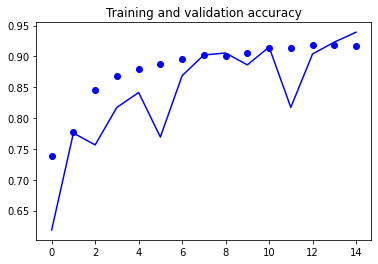

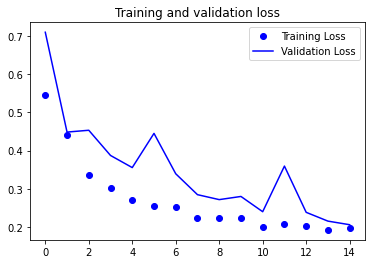

In [13]:
# #-----------------------------------------------------------
# # Retrieve a list of list results on training and test data
# # sets for each training epoch
# #-----------------------------------------------------------
# acc      = history.history[     'accuracy' ]
# val_acc  = history.history[ 'val_accuracy' ]
# loss     = history.history[    'loss' ]
# val_loss = history.history['val_loss' ]

# epochs   = range(len(acc)) # Get number of epochs

# #------------------------------------------------
# # Plot training and validation accuracy per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     acc )
# plt.plot  ( epochs, val_acc )
# plt.title ('Training and validation accuracy')
# plt.figure()

# #------------------------------------------------
# # Plot training and validation loss per epoch
# #------------------------------------------------
# plt.plot  ( epochs,     loss )
# plt.plot  ( epochs, val_loss )
# plt.title ('Training and validation loss'   )


import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()